In [224]:
import sys
sys.path.append('../lib')
from table_detection import Signal, LineDetection, Table
import cv2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
signal = np.zeros(1000)

In [5]:
signal[[200,300,700]] = 1

In [6]:
signal += 0.005*np.random.randn(1000)

In [7]:
import matplotlib.pyplot as plt

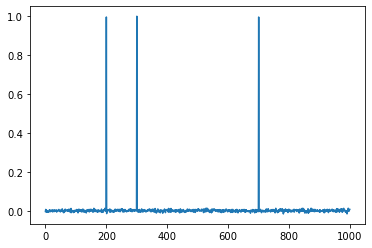

In [8]:
plt.plot(signal)

In [9]:
sgnl = Signal(signal)

In [10]:
sgnl.find_peaks(distance=15)

array([200, 300], dtype=int64)

In [11]:
img = 255*(plt.imread('../results/test_column_mask/3258563200475.nutrition.jpg')<30)

In [12]:
line_detect = LineDetection(img,(512,512))

In [13]:
line_detect.find_peaks(15,10,0)

In [14]:
line_detect.signal.find_peaks()

array([162], dtype=int64)

In [78]:
def get_sub_mask_by_removing_overfilled_borders(mask,axis):
    mask_summed_on_axis = mask.sum(axis=axis)
    indexes = np.where(mask_summed_on_axis>mask_summed_on_axis.max()*0.8)[0]
    start, end = get_biggest_gap_index(indexes)
    if axis == 1:
        mask[:start]=0
        mask[end:] = 0
    elif axis == 0:
        mask[:, :start]=0
        mask[:, end:] = 0
    return mask

In [215]:
def column_process_mask(mask):
    # Définir le pas du kernel >20 pour que les lignes verticales soient plus accentuées 
    
    #close horizontal thin lines
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    close = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel1)
    
    #get the inverse of the 
    result = (255*(close<128)).astype(np.uint8)
    
    #dilate then erode to connect "broken lines"
    kernel = np.ones((20,1), np.uint8)  # note this is a horizontal kernel
    d_im = cv2.dilate(result, kernel, iterations=1)
    e_im = cv2.erode(d_im, kernel, iterations=1)
    
    #overfilled lines borders are removed
    processed_mask = get_sub_mask_by_removing_overfilled_borders(e_im,axis=1)
    
    return processed_mask

In [79]:
def line_process_mask(mask):
    empty_mask = np.zeros((mask.shape),np.uint8)
    # Définir le pas du kernel >20 pour que les lignes verticales soient plus accentuées 
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,1))
    close = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel1)
    close = np.logical_or(close,mask).astype('uint8')
    div = np.float32(mask)/(close)
    
    kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(5,1))
    dx = cv2.Sobel(div,cv2.CV_16S,1,0)
    dx = cv2.convertScaleAbs(dx)
    cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
    ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    return get_sub_mask_by_removing_overfilled_borders(close,axis=0)

In [164]:
mask = cv2.cvtColor(plt.imread('../results/test_column_mask/3269210251580.nutrition.jpg'),cv2.COLOR_RGB2GRAY)

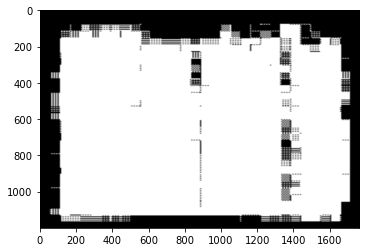

In [149]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,2))
close = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,kernel1)
div = np.float32(mask)/(close)
plt.imshow(close,cmap='gray')
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

close = np.logical_or(close,mask).astype('uint8')
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,10))
close = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel1)
div = np.float32(mask)/(close)


dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)

#
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#close = cv2.morphologyEx(close,cv2.MORPH_DILATE,kernely,iterations = 1)

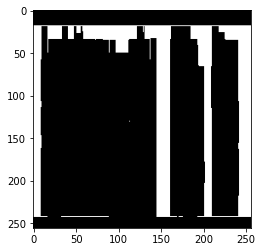

In [218]:
plt.imshow(column_process_mask(mask),cmap='gray')

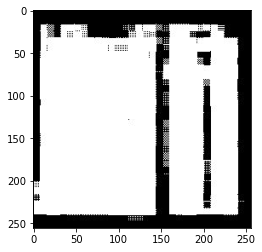

In [166]:
plt.imshow(mask,cmap='gray')

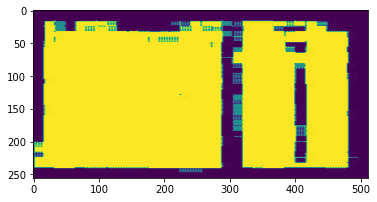

In [250]:
plt.imshow(cv2.resize(mask,(512,256)))

In [260]:
def process_line_mask(mask):
    
    #close vertical thin lines
    kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(2,5))
    close = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel1)
    
    #get the inverse of the 
    result = (255*(close<128)).astype(np.uint8)
    
    #dilate then erode to connect "broken lines"
    kernel = np.ones((1,20), np.uint8)  # note this is a horizontal kernel
    d_im = cv2.dilate(result, kernel, iterations=1)
    e_im = cv2.erode(d_im, kernel, iterations=1)
    
    #overfilled lines borders are removed
    processed_mask = get_sub_mask_by_removing_overfilled_borders(e_im,axis=0)
    
    return processed_mask

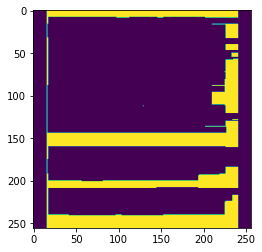

In [261]:
plt.imshow(process_line_mask(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE)))

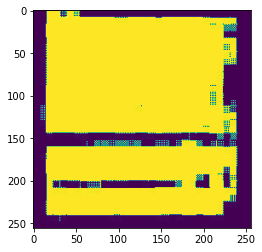

In [262]:
plt.imshow(cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE))

In [269]:
table = Table(mask,cv2.rotate(mask,cv2.ROTATE_90_CLOCKWISE),(512,512))

In [270]:
table.find_columns()

In [271]:
table.find_table()

In [272]:
table.table

[[Rectangle(xmin=0, ymin=0, xmax=296, ymax=302),
  Rectangle(xmin=0, ymin=302, xmax=296, ymax=402),
  Rectangle(xmin=0, ymin=402, xmax=296, ymax=512)],
 [Rectangle(xmin=296, ymin=0, xmax=392, ymax=302),
  Rectangle(xmin=296, ymin=302, xmax=392, ymax=402),
  Rectangle(xmin=296, ymin=402, xmax=392, ymax=512)],
 [Rectangle(xmin=392, ymin=0, xmax=512, ymax=302),
  Rectangle(xmin=392, ymin=302, xmax=512, ymax=402),
  Rectangle(xmin=392, ymin=402, xmax=512, ymax=512)]]

In [ ]:
plt.imshow()

In [236]:
def runningMean(x, N):
    y = np.zeros((len(x),))
    for ctr in range(len(x)):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

In [237]:
runningMean(column_process_mask(mask).sum(axis=0),25)

array([22909.2, 20777.4, 18645.6, 16513.8, 14382. , 12250.2, 10118.4,
        7986.6,  5854.8,  3733.2,  3111. ,  3111. ,  3111. ,  3111. ,
        3111. ,  3111. ,  3111. ,  3264. ,  3111. ,  3121.2,  3131.4,
        3141.6,  3151.8,  3162. ,  3019.2,  2876.4,  2733.6,  2672.4,
        2611.2,  2550. ,  2488.8,  2427.6,  2284.8,  2142. ,  2050.2,
        2203.2,  2356.2,  2509.2,  2662.2,  2815.2,  2968.2,  3121.2,
        3121.2,  3121.2,  3121.2,  3121.2,  3121.2,  3121.2,  3121.2,
        3284.4,  3437.4,  3590.4,  3661.8,  3733.2,  3804.6,  3876. ,
        3947.4,  4100.4,  4263.6,  4365.6,  4375.8,  4386. ,  4396.2,
        4406.4,  4416.6,  4569.6,  4569.6,  4569.6,  4569.6,  4569.6,
        4569.6,  4569.6,  4569.6,  4722.6,  4865.4,  5018.4,  5171.4,
        5324.4,  5477.4,  5630.4,  5783.4,  5936.4,  6089.4,  6232.2,
        6375. ,  6517.8,  6660.6,  6803.4,  6793.2,  6783. ,  6619.8,
        6609.6,  6599.4,  6589.2,  6579. ,  6568.8,  6558.6,  6548.4,
        6232.2,  591